In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import cv2 as cv


In [2]:

class CustomDataset(Dataset):
    def __init__(self, root_dir, classes, class_dic, transform = None):
        self.annotations = []
        self.classes = []
        for c in classes:
          for file in os.listdir(root+c):
            #if file.endswith(".jpg"):
            self.annotations.append(root+c+'/'+file)
            self.classes.append(class_dic[c])
        self.root_dir = root_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        image = cv.imread(self.annotations[index],cv.IMREAD_GRAYSCALE)
        norm_image = image/255
        y = self.classes[index]
        y_label = torch.tensor(int(y))

        if self.transform:
            norm_image = self.transform(image)
        return (norm_image, y_label)
        

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
root='./dataset/'

print(device)
classes = []
class_dic = {}

j = 0
for file in sorted(os.listdir(root)):
    d = os.path.join(root, file)
    if os.path.isdir(d):
        classes.append(file)
        class_dic[file] = j
        j=j+1
print(classes)
print(class_dic)
#classes = ['solid','checkered_resize', 'striped_resize', "dotted_resize"]
#class_dic ={'striped_resize':0,'dotted_resize':1,'checkered_resize':2,'solid':3}


num_epochs = 10
batch_size = 4
learning_rate = 0.001

cpu
['checkered_resize', 'solid', 'dotted_resize', 'striped_resize']
{'checkered_resize': 0, 'solid': 1, 'dotted_resize': 2, 'striped_resize': 3}


In [23]:
from math import *

dataset = CustomDataset(root_dir=root, classes=classes, class_dic=class_dic, transform=transforms.ToTensor())
length = dataset.__len__()

train_set, test_set = torch.utils.data.random_split(dataset, [length-floor(length/5), floor(length/5)])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True,)


In [24]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(288, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 288)
        x = F.softmax(self.fc1(x),dim=1)
        return x

In [25]:
model = ConvNet().to(device)
print(length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


9565


In [27]:
n_total_steps = len(train_loader)
loss_value = []
for epoch in range(num_epochs):
    print(epoch+1)
    running_loss=0.0
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i+1) % 200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / (length-floor(length/5))
    loss_value.append(epoch_loss)
print('Finished Training')


1


AttributeError: 'tuple' object has no attribute 'to'

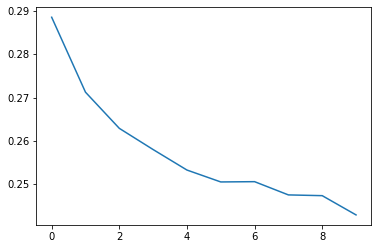

In [11]:
plt.plot(loss_value)
PATH = root + '/cnn.pth'
torch.save(model.state_dict(), PATH)

In [13]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(len(classes))]
    n_class_samples = [0 for i in range(len(classes))]
    j=0
    length2 = len(test_loader)
    for images, labels in test_loader:
        if j % 100 == 0:
          print(i)
          print(labels)
        j=j+1
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            try:
              label = labels[i]
            except:
              print(labels)
              break
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(len(classes)):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of the network {acc}')
        print(classes[i])

3
tensor([0, 2, 1, 2])
3
tensor([1, 1, 0, 1])
3
tensor([1, 3, 1, 1])
3
tensor([0, 3, 1, 2])
3
tensor([2, 0, 0, 2])
tensor([0])
Accuracy of the network: 63.30371144798745 %
Accuracy of the network 88.19188191881919
solid
Accuracy of the network 45.05494505494506
checkered_resize
Accuracy of the network 61.20401337792642
striped_resize
Accuracy of the network 53.30396475770925
dotted_resize


In [28]:
import coremltools as ct

model = ConvNet()
model.load_state_dict(torch.load('cnn.pth'))

# Create dummy input
dummy_input = torch.rand(1, 1, 150, 150)
traced_model = torch.jit.trace(model, dummy_input)

class_labels = [0,1,2,3]
classifier_config = ct.ClassifierConfig(class_labels)

_input =ct.ImageType(name="input_1",shape=(1,1,150,150),scale = 1./255)

mlmodel = ct.convert(traced_model, inputs=[_input], classifier_config=classifier_config)

mlmodel.save("tesstmodel.mlmodel")

Running MIL Common passes:   0%|          | 0/34 [00:00<?, ? passes/s]/Users/alexandrebarbier/Library/Python/3.8/lib/python/site-packages/coremltools/converters/mil/mil/passes/name_sanitization_utils.py:129: UserWarning: Output, '78', of the source model, has been renamed to 'var_78' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 52/52 [00:00<00:00, 1900.87 ops/s]
